# Beamforming (pytorch, geographical coordinates)

In this notebook, we locate the source of a synthetic wavefield recorded on an array of sensors using beamforming. The notebook follows three steps:

1. Geometry: define the geometry of sensors, source, and gridpoints to test
2. Recordings (synthetic): compute synthetic seismograms recorded on each sensor
3. Beamforming: compute cross-correlation beamformer output within a frequency band

For more background information, see the README.

## Geographical coordinates

The only difference between beamforming on a cartesian and geographical grid lies on how distances are computed. I looked around a bit and found [geokernels](https://github.com/sigmaterra/geokernels) to be quite performant. One could also do an implementation using obspy’s gps2dist_azimuth, or the underlying geographiclib. In any case, distances only need to be computed once, so that's not a likely bottleneck. Note that time windows need to be long enough that waves can travel large distances. This puts constrains on the other parameters. If you run out of memory, consider adapting the `dask` version.

## 1. Geometry

Text(0.5, 1.0, 'geometry of sensors, source, and grid')

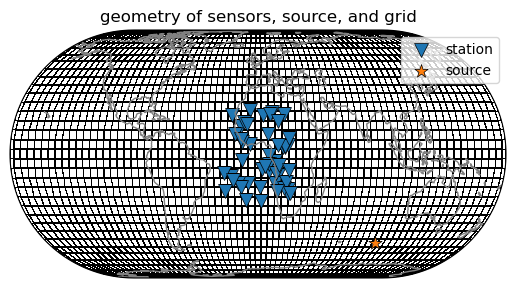

In [1]:
from itertools import product

import cartopy.crs as ccrs
from geokernels.distance import geodist
import pylab as plt
import numpy as np
import torch

torch.manual_seed(42)

# geometry of the problem
n_sensors = 50
# uniform random distribution in [-25, 25]
# coordinates defined in lon, lat
stations = torch.rand((n_sensors, 2)) * 50
stations -= 25
source = torch.tensor([100, -50])

# geographic grid
grid_spacing = 5
grid_coords_lon = torch.arange(-180, 180, grid_spacing)
grid_coords_lat = torch.arange(-90, 90, grid_spacing)
gridpoints = torch.tensor(list(product(grid_coords_lat, grid_coords_lon)))

# generate empty grid cells for visulation
# xx, yy = torch.meshgrid(grid_coords, grid_coords, indexing="xy")
xx, yy = torch.meshgrid(grid_coords_lon, grid_coords_lat, indexing="xy")
empty_cells = torch.zeros_like(xx) * torch.nan

# plotting
fig, ax = plt.subplots(1, subplot_kw={"projection": ccrs.EckertIV()})
ax.pcolormesh(xx, yy, empty_cells, ec="k", lw=0.01, transform=ccrs.PlateCarree())
ax.scatter(
    *stations.T,
    marker="v",
    s=100,
    label="station",
    ec="k",
    lw=0.5,
    transform=ccrs.PlateCarree()
)
ax.scatter(
    *source,
    marker="*",
    s=100,
    label="source",
    ec="k",
    lw=0.5,
    transform=ccrs.PlateCarree()
)
ax.coastlines(color="grey")
ax.set_global()
ax.legend(loc=1)
ax.set_title("geometry of sensors, source, and grid")

## 2. Recordings (synthetic)

In a field data application, replace `waveform_spectra` by the spectra of your recordings.

/tmp/ipykernel_59277/3615818426.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch_1686931851744/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  distances = torch.tensor(distances).T


Text(0.5, 1.0, '(synthetic) recordings on sensors')

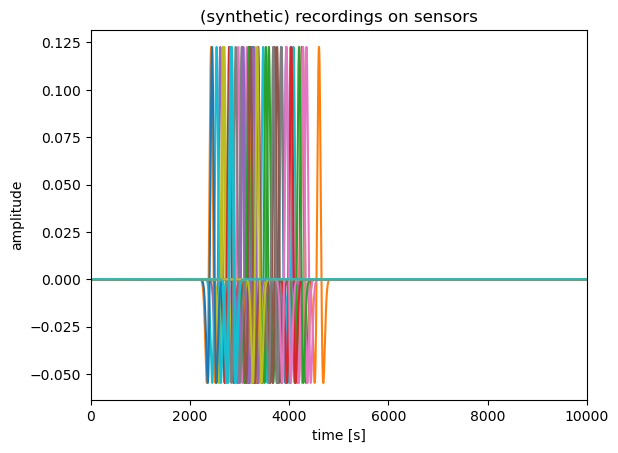

In [2]:
from scipy.signal import ricker

# define time
window_length = 10000
sampling_rate = 1
times = torch.arange(0, window_length + 1 / sampling_rate, 1 / sampling_rate)

# compute frequencies
freqs = torch.fft.fftfreq(len(times), 1 / sampling_rate)
omega = 2 * torch.pi * freqs

# define medium
# acoustic homogeneous half-space
medium_velocity = 3

# compute travel times
distances = torch.linalg.norm(stations - source, axis=1)


# for geodist, both tensors need to have the same shape
# flip, because geodist expects (lat, lon) instead of (lon, lat)
source_e = source.flip(0).repeat(stations.shape[0], 1)
distances = geodist(stations.flip(1), source_e, metric="km")
distances = torch.tensor(distances).T

traveltimes_to_source = distances / medium_velocity

# define source wavelet
wavelet = torch.fft.fft(torch.from_numpy(ricker(len(times), 50 * sampling_rate)))

# compute waveforms for all stations for given source
# Green's functions are exp(-iωt)
# waveforms are only computed for plotting purposes.
# In a usual field data application, waveforms already exist
# and waveform_spectra need to be computed.
waveform_spectra = wavelet * torch.exp(
    -1j * omega[None, :] * traveltimes_to_source[:, None]
)
waveforms = torch.fft.fftshift(torch.fft.ifft(waveform_spectra, axis=1).real)

# plotting
fig, ax = plt.subplots(1)
ax.plot(times, waveforms.T)
ax.set_xlim(0, window_length)
ax.set_xlabel("time [s]")
ax.set_ylabel("amplitude")
ax.set_title("(synthetic) recordings on sensors")

## 3. Beamforming

Here, we compute beampowers using cross-correlation beamforming

$B(\mathbf{r_s}) = \sum_\omega \sum_j \sum_{k\neq j} K_{jk}(\omega) S_{kj}(\mathbf{r_s}, \omega)$,

with $B$ the beampower for potential source location $\mathbf{r_s}$, $j,k$ the sensors indices, $K$ the cross-spectral density matrix of recorded signals, and $S$ the cross-spectral density matrix of Green's functions (or replica vectors). For more details, see the README.

**Note on plane-wave beamforming**

The kind of beamforming here is Matched Field Processing, i.e., testing a spatial grid and not a slowness grid. For plane-wave beamforming, make three changes to this notebook:
1. Change the grid from spatial ($x, y$) to horizontal slownesses ($u_x, u_y$)
2. Adapt the computation of travel times to $t = u_x x_j + u_y y_j$, where $x_j, y_j$ is the position of sensor $j$ relative to a reference point.
3. Plot slowness grid instead of spatial view for beamforming result

In [3]:
# Frequency band to use for beamform
# Frequencies chosen much lower than for the other examples for visualisation purposes.
# If frequncies are higher, the beamforming result is more focused.
fmin, fmax = 0.001, 0.002

# theoretical traveltimes between all stations and all grid points
# Note that in this demonstration we know the velocity of the medium.
# In a field data application, medium_velocity may be another dimension to test.
# In that case, you can keep changes to the remaining logic minimal by
# keeping traveltimes as 1D tensor, i.e., with contents (gp1_v1, gp1_v2, ... gpN_vN-1, gpN_vN).

# distances on earth using geokernels
# there must be a better way to do this, but this is acceptable for now.
# at the moment not aware of a way to fully vectorize this.
# for geodist, both tensors need to have the same shape.
# flip, because geodist expects (lat, lon) instead of (lon, lat),
# gridpoints are already defined that way.
dists = [
    geodist(gridpoints, sta.flip(0).repeat(gridpoints.shape[0], 1), metric="km")
    for sta in stations
]
dists = torch.tensor(np.array(dists)).T

traveltimes = dists / medium_velocity

# limit to frequency band of interest for
# a) speed-up
# b) focusing on specific frequencies
freq_idx = torch.where((freqs > fmin) & (freqs < fmax))[0]
omega_lim = omega[freq_idx]
waveform_spectra_lim = waveform_spectra[:, freq_idx]

# Green's functions between all stations and all grid points
# within selected frequency band
# G = exp(-iωt)
greens_functions = torch.exp(-1j * omega_lim[None, None, :] * traveltimes[:, :, None])

# force complexdouble type
# fixes type mismatch that arises from 1j -> cfloat, but fft -> cdouble
greens_functions = greens_functions.type(torch.cdouble)

# cross-spectral density matrix of Green's functions
S = greens_functions[:, :, None, :] * greens_functions.conj()[:, None, :, :]

# cross-spectral density matrix of recordings
K = waveform_spectra_lim[:, None, :] * waveform_spectra_lim.conj()[None, :, :]

# exclude auto-correlations, i.e., do "cross-correlation beamforming"
diag_idxs = torch.arange(K.shape[0])
zero_spectra = torch.zeros(omega_lim.shape, dtype=torch.cdouble)
K[diag_idxs, diag_idxs, :] = zero_spectra

# Compute cross-correlation beampower
# using einsum, which automatically identifies ideal path
# this is about 2x faster than numpy einsum from my experience
beampowers = torch.einsum("xjkw, kjw -> x", S, K).real

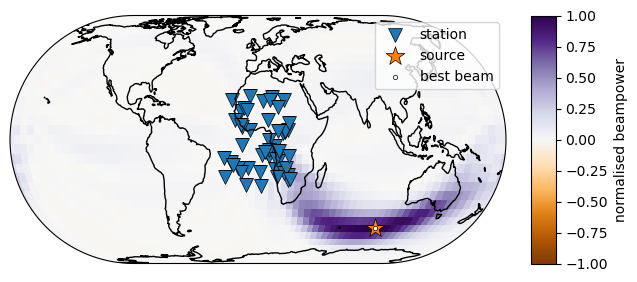

In [4]:
# plot beamforming result
fig, ax = plt.subplots(1, subplot_kw={"projection": ccrs.EckertIV()})

bp = beampowers.reshape(len(grid_coords_lat), len(grid_coords_lon))
bp /= abs(bp).max()
pcm = ax.pcolormesh(
    xx, yy, bp, cmap="PuOr", vmin=-1, vmax=1, transform=ccrs.PlateCarree()
)
ax.scatter(
    *stations.T,
    marker="v",
    s=100,
    label="station",
    ec="k",
    lw=0.5,
    transform=ccrs.PlateCarree()
)
ax.scatter(
    *source,
    marker="*",
    s=200,
    label="source",
    ec="k",
    lw=0.5,
    transform=ccrs.PlateCarree()
)
ax.scatter(
    *gridpoints[bp.argmax()].flip(0),
    marker="o",
    ec="k",
    lw=0.5,
    c="w",
    s=10,
    label="best beam",
    transform=ccrs.PlateCarree()
)

x0, y0, w, h = ax.get_position().bounds
cax = fig.add_axes([x0 + w + 0.05*w, y0, 0.05*w, h])
plt.colorbar(pcm, label="normalised beampower", cax=cax)
ax.coastlines()
ax.set_global()
ax.legend(loc=1)